<a href="https://colab.research.google.com/github/sudotouchwoman/math-misc/blob/main/notebooks/generic-sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [ ]:
sns.set(rc={'figure.figsize':(20,12), 'figure.dpi':300})

In [ ]:
a = 3
b = 2
C = 0
t_0 = -4
t_n = 4
h = 2e-1

In [ ]:
sigmoid = lambda t: a / (np.exp(-a*t-C) + b)

In [ ]:
def euler_2nd_order(t, w_0, h):
  w_i = w_0
  w_next = lambda w: w + h * (a*w - b*w**2 + h/2*(a - 2*b*w)*(a*w - b*w**2))
  yield w_0
  for i, t_i in enumerate(t[1:]):
    w_i = w_next(w_i)
    yield w_i

In [ ]:
t_ = np.arange(t_0, t_n + h, h)
analytical = sigmoid(t_)
numerical = list(euler_2nd_order(t_, analytical[0], h))

Plot the analytical solution of ODE and its approximation (seminar problem 5.4)

Afterwards I added code from the `lab3` to test the performance of methods on known convergent ODE. The results are quite predictable

Error surface for both `h` and `t` could be a nice idea, though I am unsure whether Colab is capable of handling such load

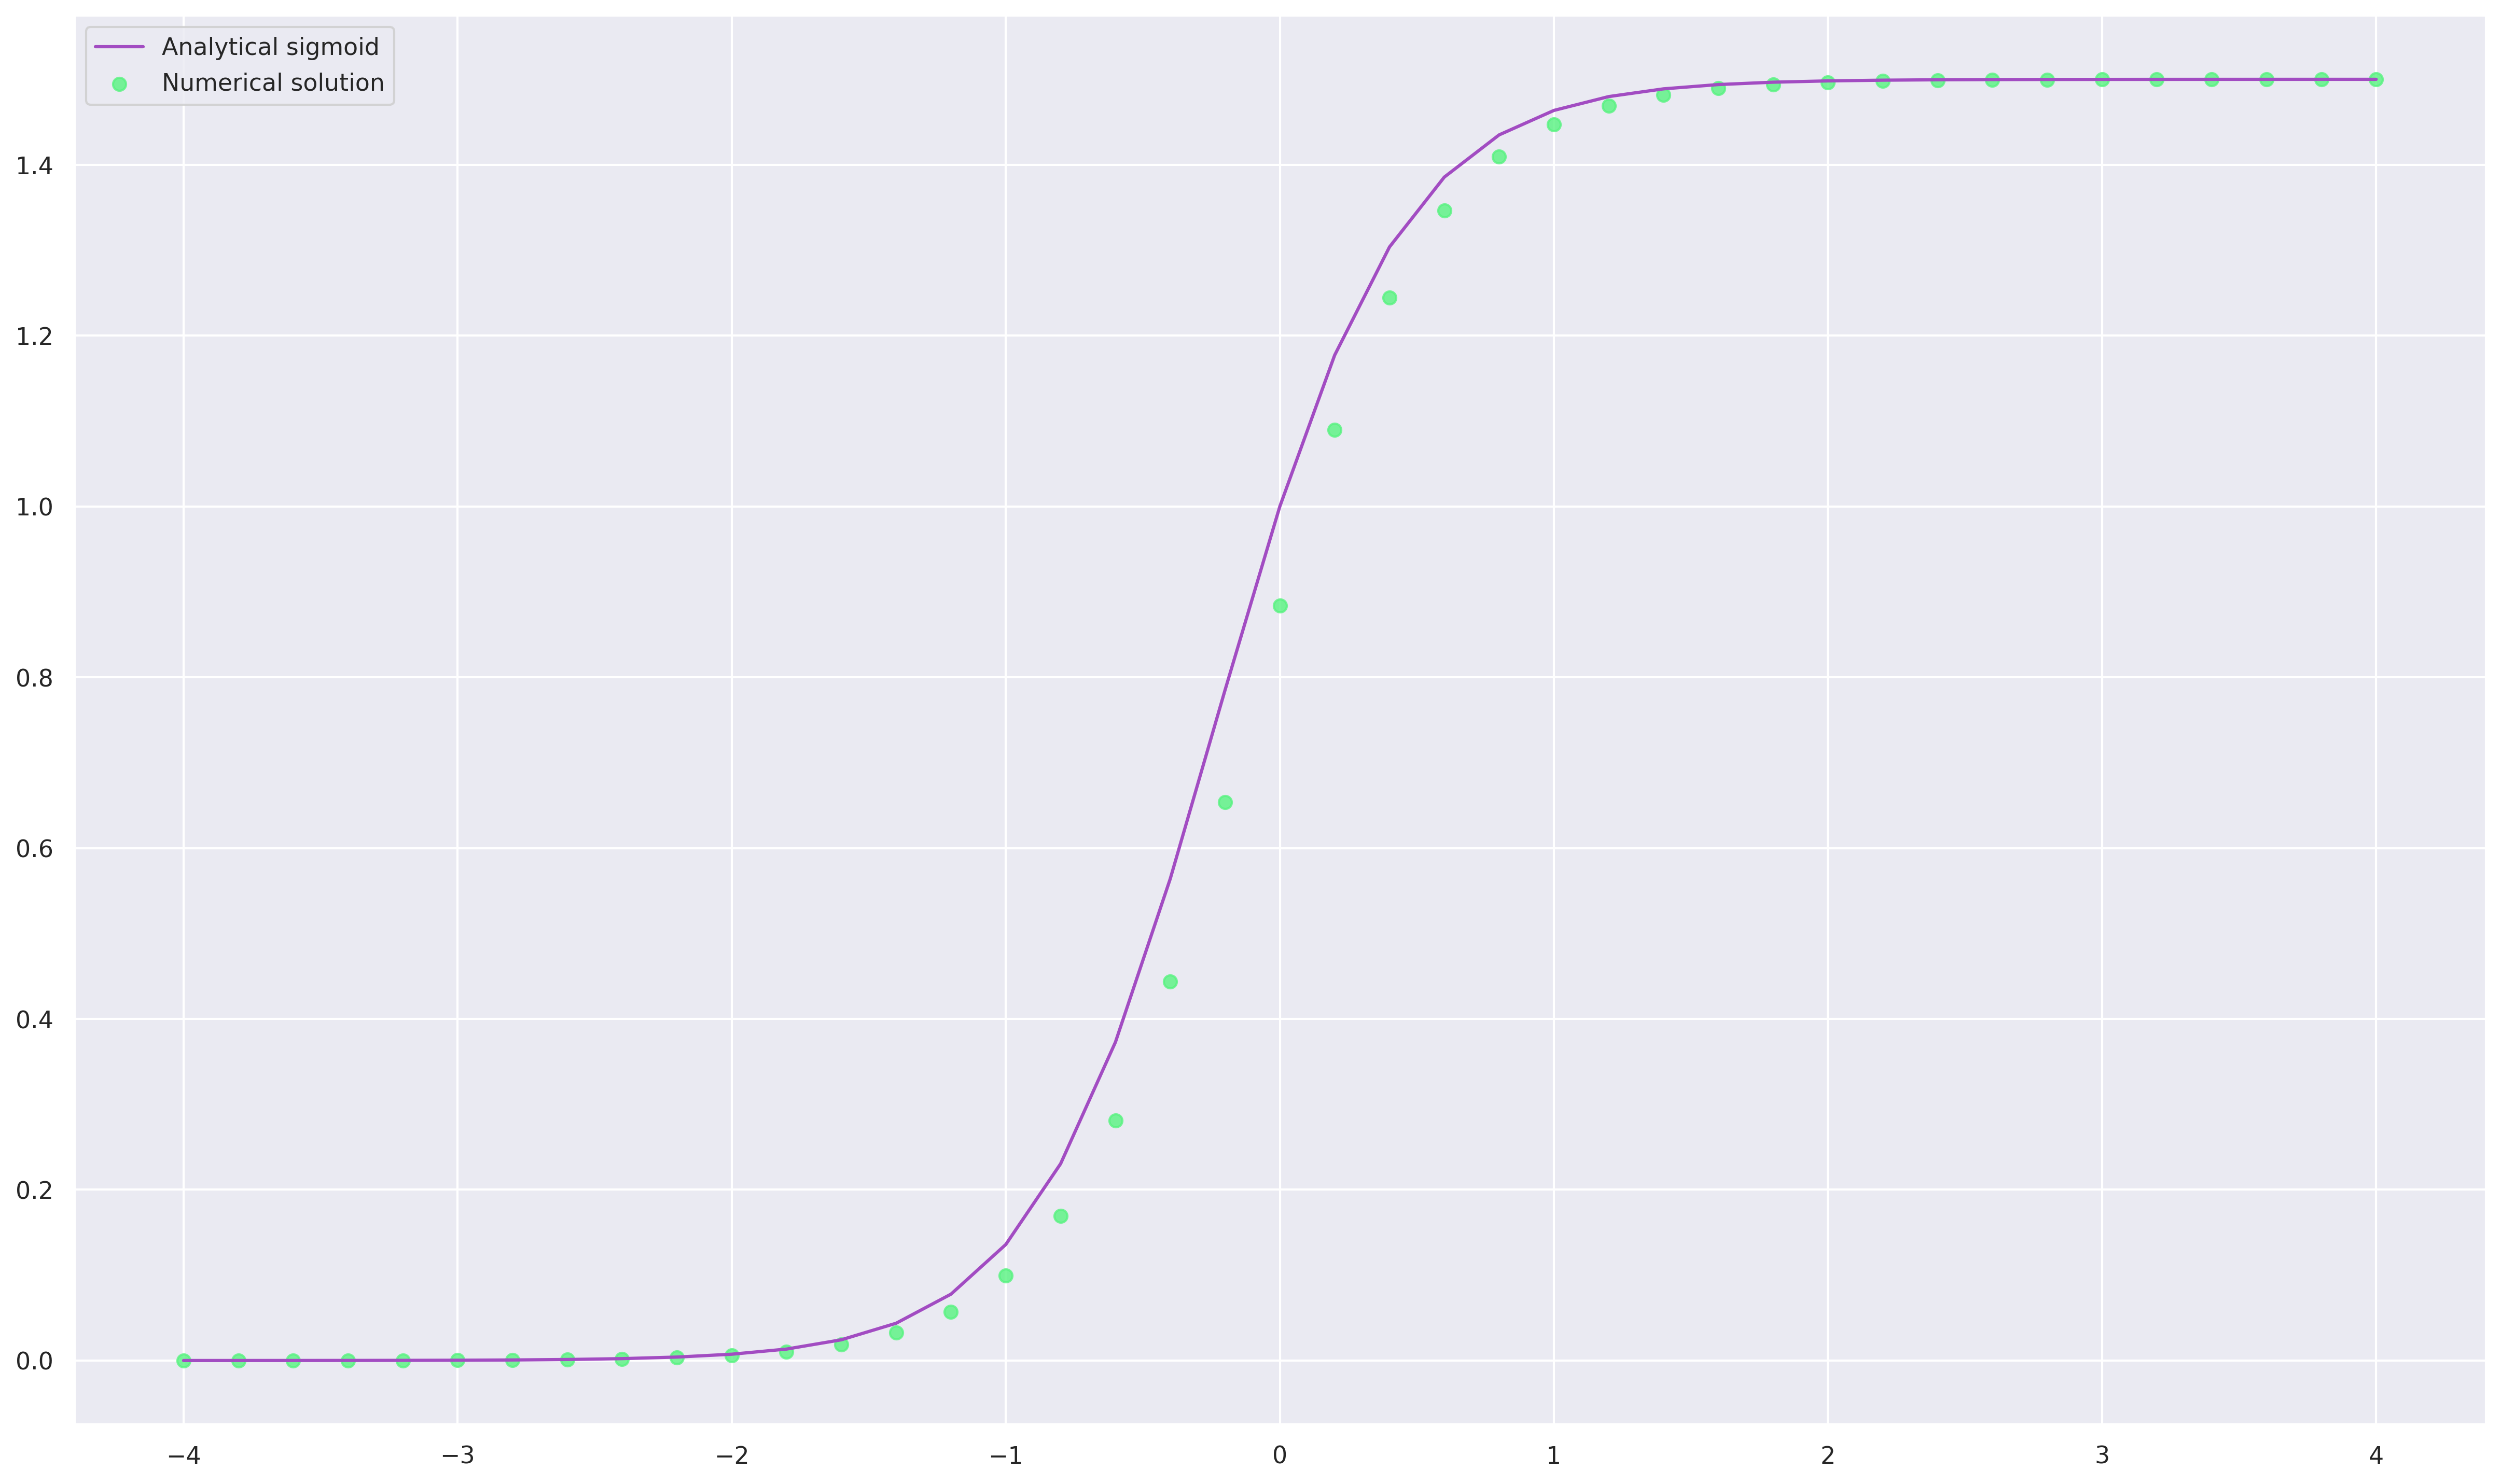

In [ ]:
plt.plot(t_, analytical, color='#A24CC2', label='Analytical sigmoid')
plt.scatter(t_, numerical, alpha=.8, c='#58F380', label='Numerical solution')
plt.legend(loc='best')
plt.show()

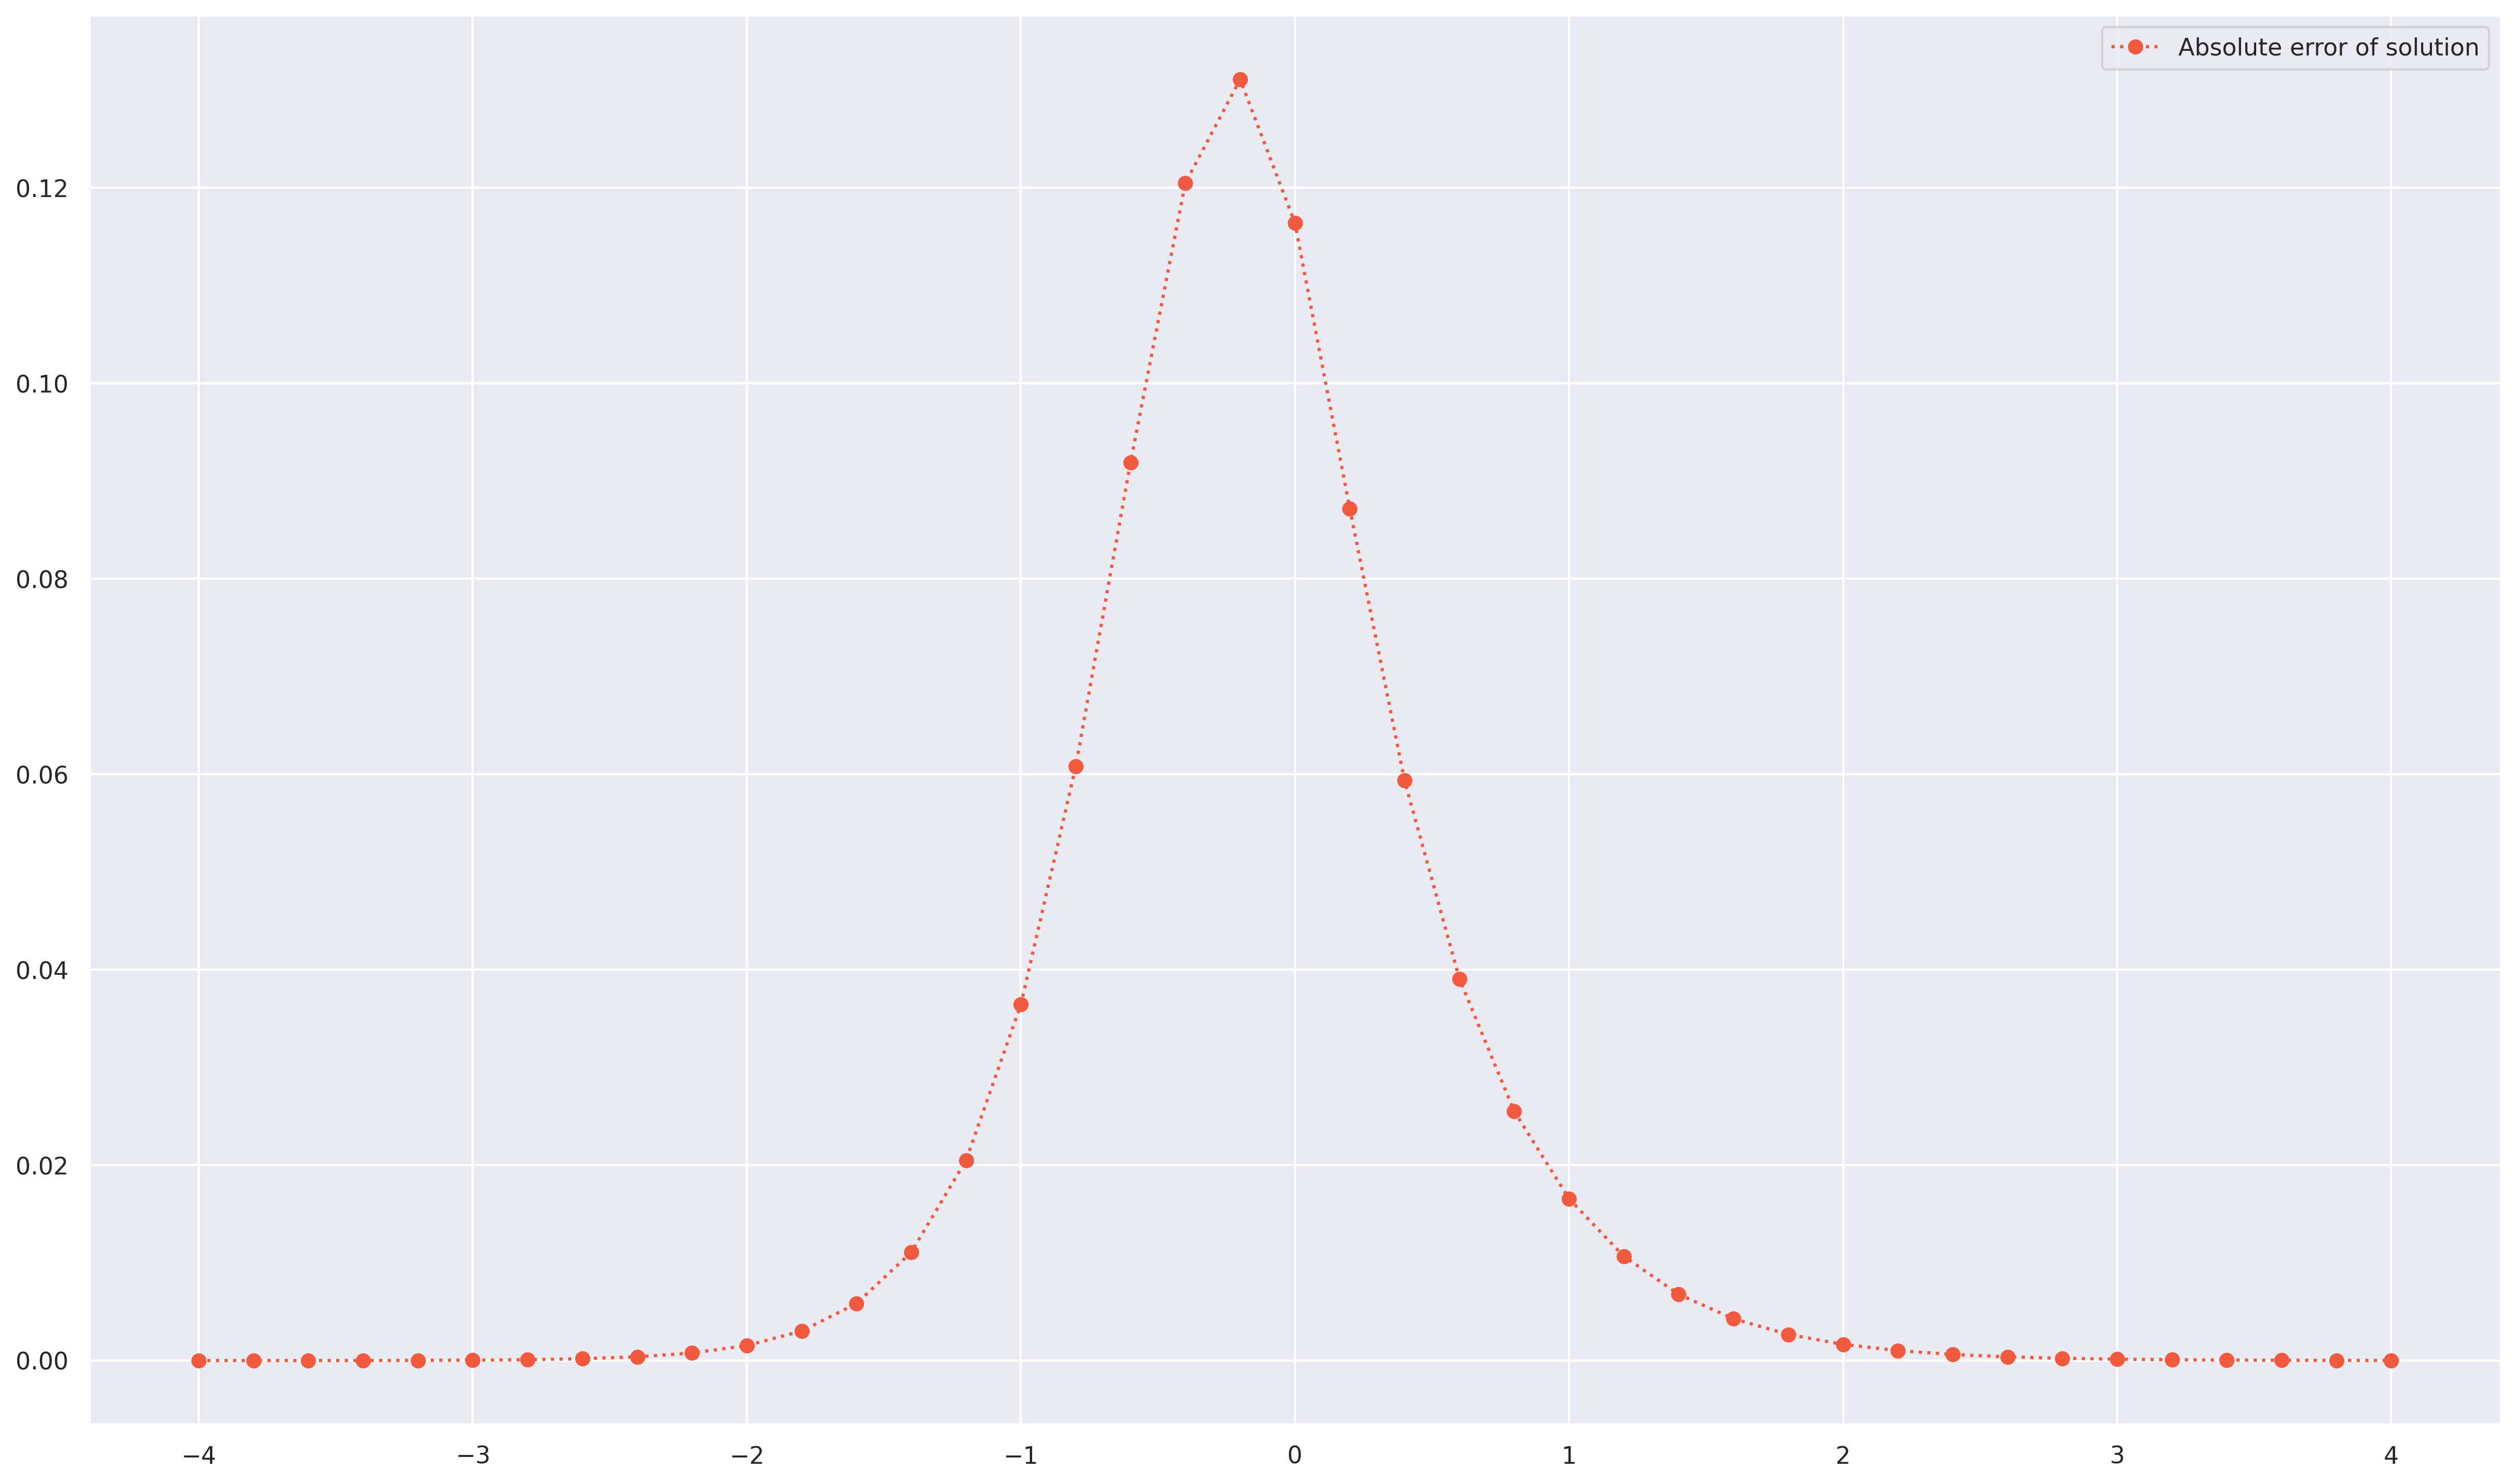

In [ ]:
plt.plot(t_, (analytical - numerical), color='#F25A40', label='Absolute error of solution', linestyle=':', marker='o')
plt.legend(loc='best')
plt.show()

In [ ]:
pd.DataFrame({'t':(t_.round(1)), 'error':(analytical - numerical)})

Notably, the error plot resembles the normal distribution PDF (aka gaussoid), while the sigmoid itself looks like its CDF. **However**, as I found out on Medium and Wiki, that the sigmoid is CDF of another distribution called Logistic distribution, which looks pretty simular to normal one but has heavier tails (higher kurtosis), Nice new acknowledgement

In the cells beneath the same ODE is used to test my solver

In [ ]:
from scipy.optimize import root
def solve_ode(x_0: list or np.ndarray, t_n: np.number, f, constraint=None, t_0=.0, h=5e-1, method='euler'):
    '''
    the function implements solvers for systems of ordinal differential equations, represented by a single
    vector-function of single independent variable

    + `x_0`: `list` or `np.ndarray` - the initial condition of dynamic system

    + `t_n`: `np.number` - the right bound independent variable value

    + `f`: function, the right part of the ODE

    + `constraint`: callable, is called to validate output of the method at each step

    + `t_0`: `np.number` - the left bound independent variable value

    + `h`: float, should be less then `t_n - t_0`, the computation step

    + `method`: one of (`euler`, `imp-euler`, `runge-kutta`). the method to use to obtain numeric solution of the ODE.
    Note that 'euler' has pretty bad accuracy (the worst, actually), 'imp-euler', representing backward (implicit) Euler method
    uses `root` to find numeric solution of the non-linear equation at each step thus is vulnerable to function shape
    'runge-kutta' utilizes 4-th order Runge-Kutta method which has greater accuracy but is significantly slower as it makes 4 calls
    to `f` per step
    '''

    methods = ('euler', 'imp-euler', 'runge-kutta')
    if method not in methods: raise ValueError(f'Invalid method name, expected one of {methods}')

    if t_n < t_0: raise ValueError(f'Invalid t bounds')
    if t_n < t_0 + h : raise ValueError(f'The step value is too big')
    if not callable(f): raise TypeError('f provided is not a callable')
    if constraint is not None and not callable(constraint): raise TypeError('User-provided constraint should be a callable')
    if constraint is None: constraint = lambda t, x: x

    x_0 = np.asarray(x_0)
    t_space = np.arange(t_0, t_n + h, step=h)
    f_space = np.zeros(shape=(len(t_space), len(x_0)))
    f_space[0] = x_0

    def euler():
        for i, t in enumerate(t_space[:-1]):
            w = f_space[i]
            w = w + h*f(t, w)
            f_space[i+1] = constraint(t, w)
        return dict(t=t_space, y=f_space)

    def imp_euler():
        for i, t in enumerate(t_space[:-1]):
            w = f_space[i]
            sol = root(lambda x: w - x + h*f(t, x), w, method='hybr')
            w =  sol.x[0] if len(sol.x) == 1 else sol.x
            f_space[i+1] = constraint(t, w)
        return dict(t=t_space, y=f_space)

    def runge_kutta():
        for i, t in enumerate(t_space[:-1]):
            w = f_space[i]

            k1 = h * f(t, w)
            k2 = h * f(t + .5*h, w + .5*k1)
            k3 = h * f(t + .5*h, w + .5*k2)
            k4 = h * f(t + h, w + k3)

            w = w + (k1 + 2*k2 + 2*k3 + k4) / 6
            f_space[i+1] = constraint(t, w)
        return dict(t=t_space, y=f_space)

    methods = dict(zip(methods, (euler, imp_euler, runge_kutta)))
    return methods[method]()

In [ ]:
f = lambda t, y: a*y - b*y**2
h = 2e-2
t_ = np.arange(t_0, t_n + h, h)
analytical = sigmoid(t_)

h = 1e-1

f_euler_sol = solve_ode([analytical[0]], f=f, t_0=t_0, t_n=t_n, h=h, method='euler')
imp_euler_sol = solve_ode([analytical[0]], f=f, t_0=t_0, t_n=t_n, h=h, method='imp-euler')
runge_sol = solve_ode([analytical[0]], f=f, t_0=t_0, t_n=t_n, h=h, method='runge-kutta')

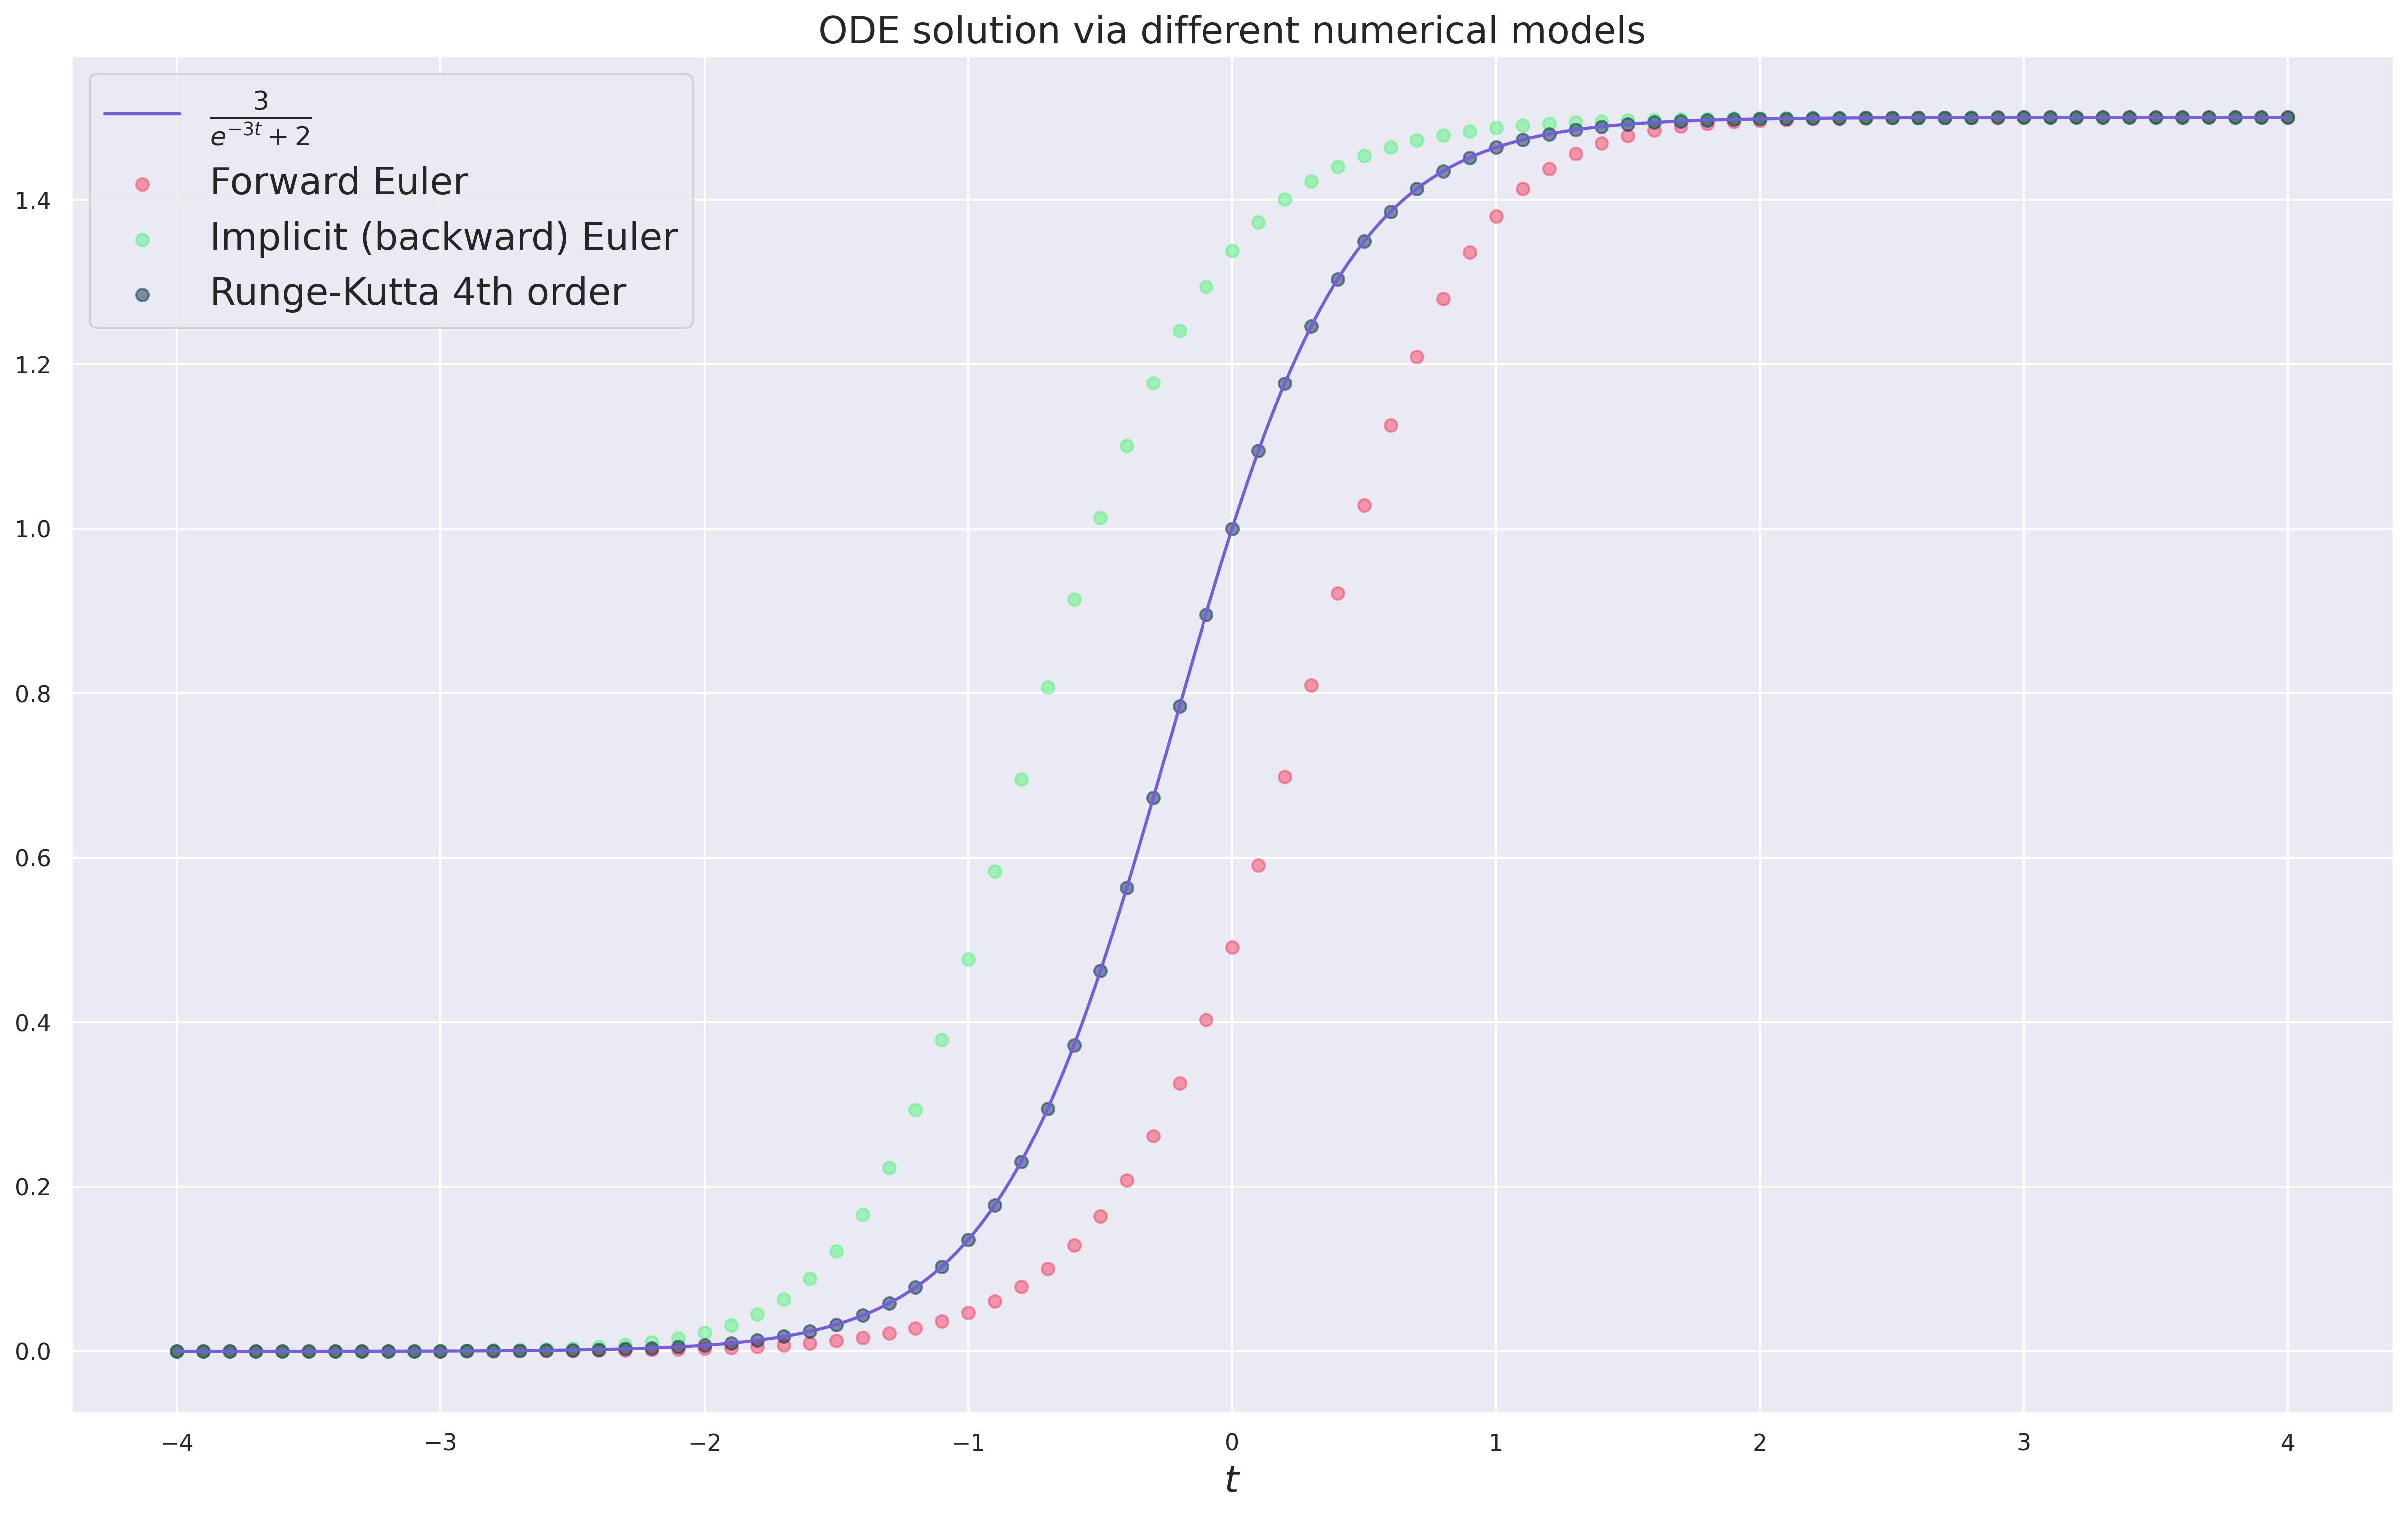

In [ ]:
plt.title('ODE solution via different numerical models', fontsize=18)
plt.plot(t_, analytical, color='#745ed9'.upper(), label=r'$\frac{3}{e^{-3t}+2}$')
for sol, label, color in zip(
    (f_euler_sol, imp_euler_sol, runge_sol),
    ('Forward Euler', 'Implicit (backward) Euler', 'Runge-Kutta 4th order'),
    ('#F24162', '#58F380', '#092E51')):
  plt.scatter(sol['t'], sol['y'], alpha=.5, label=label, c=color)
plt.xlabel(r'$t$', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

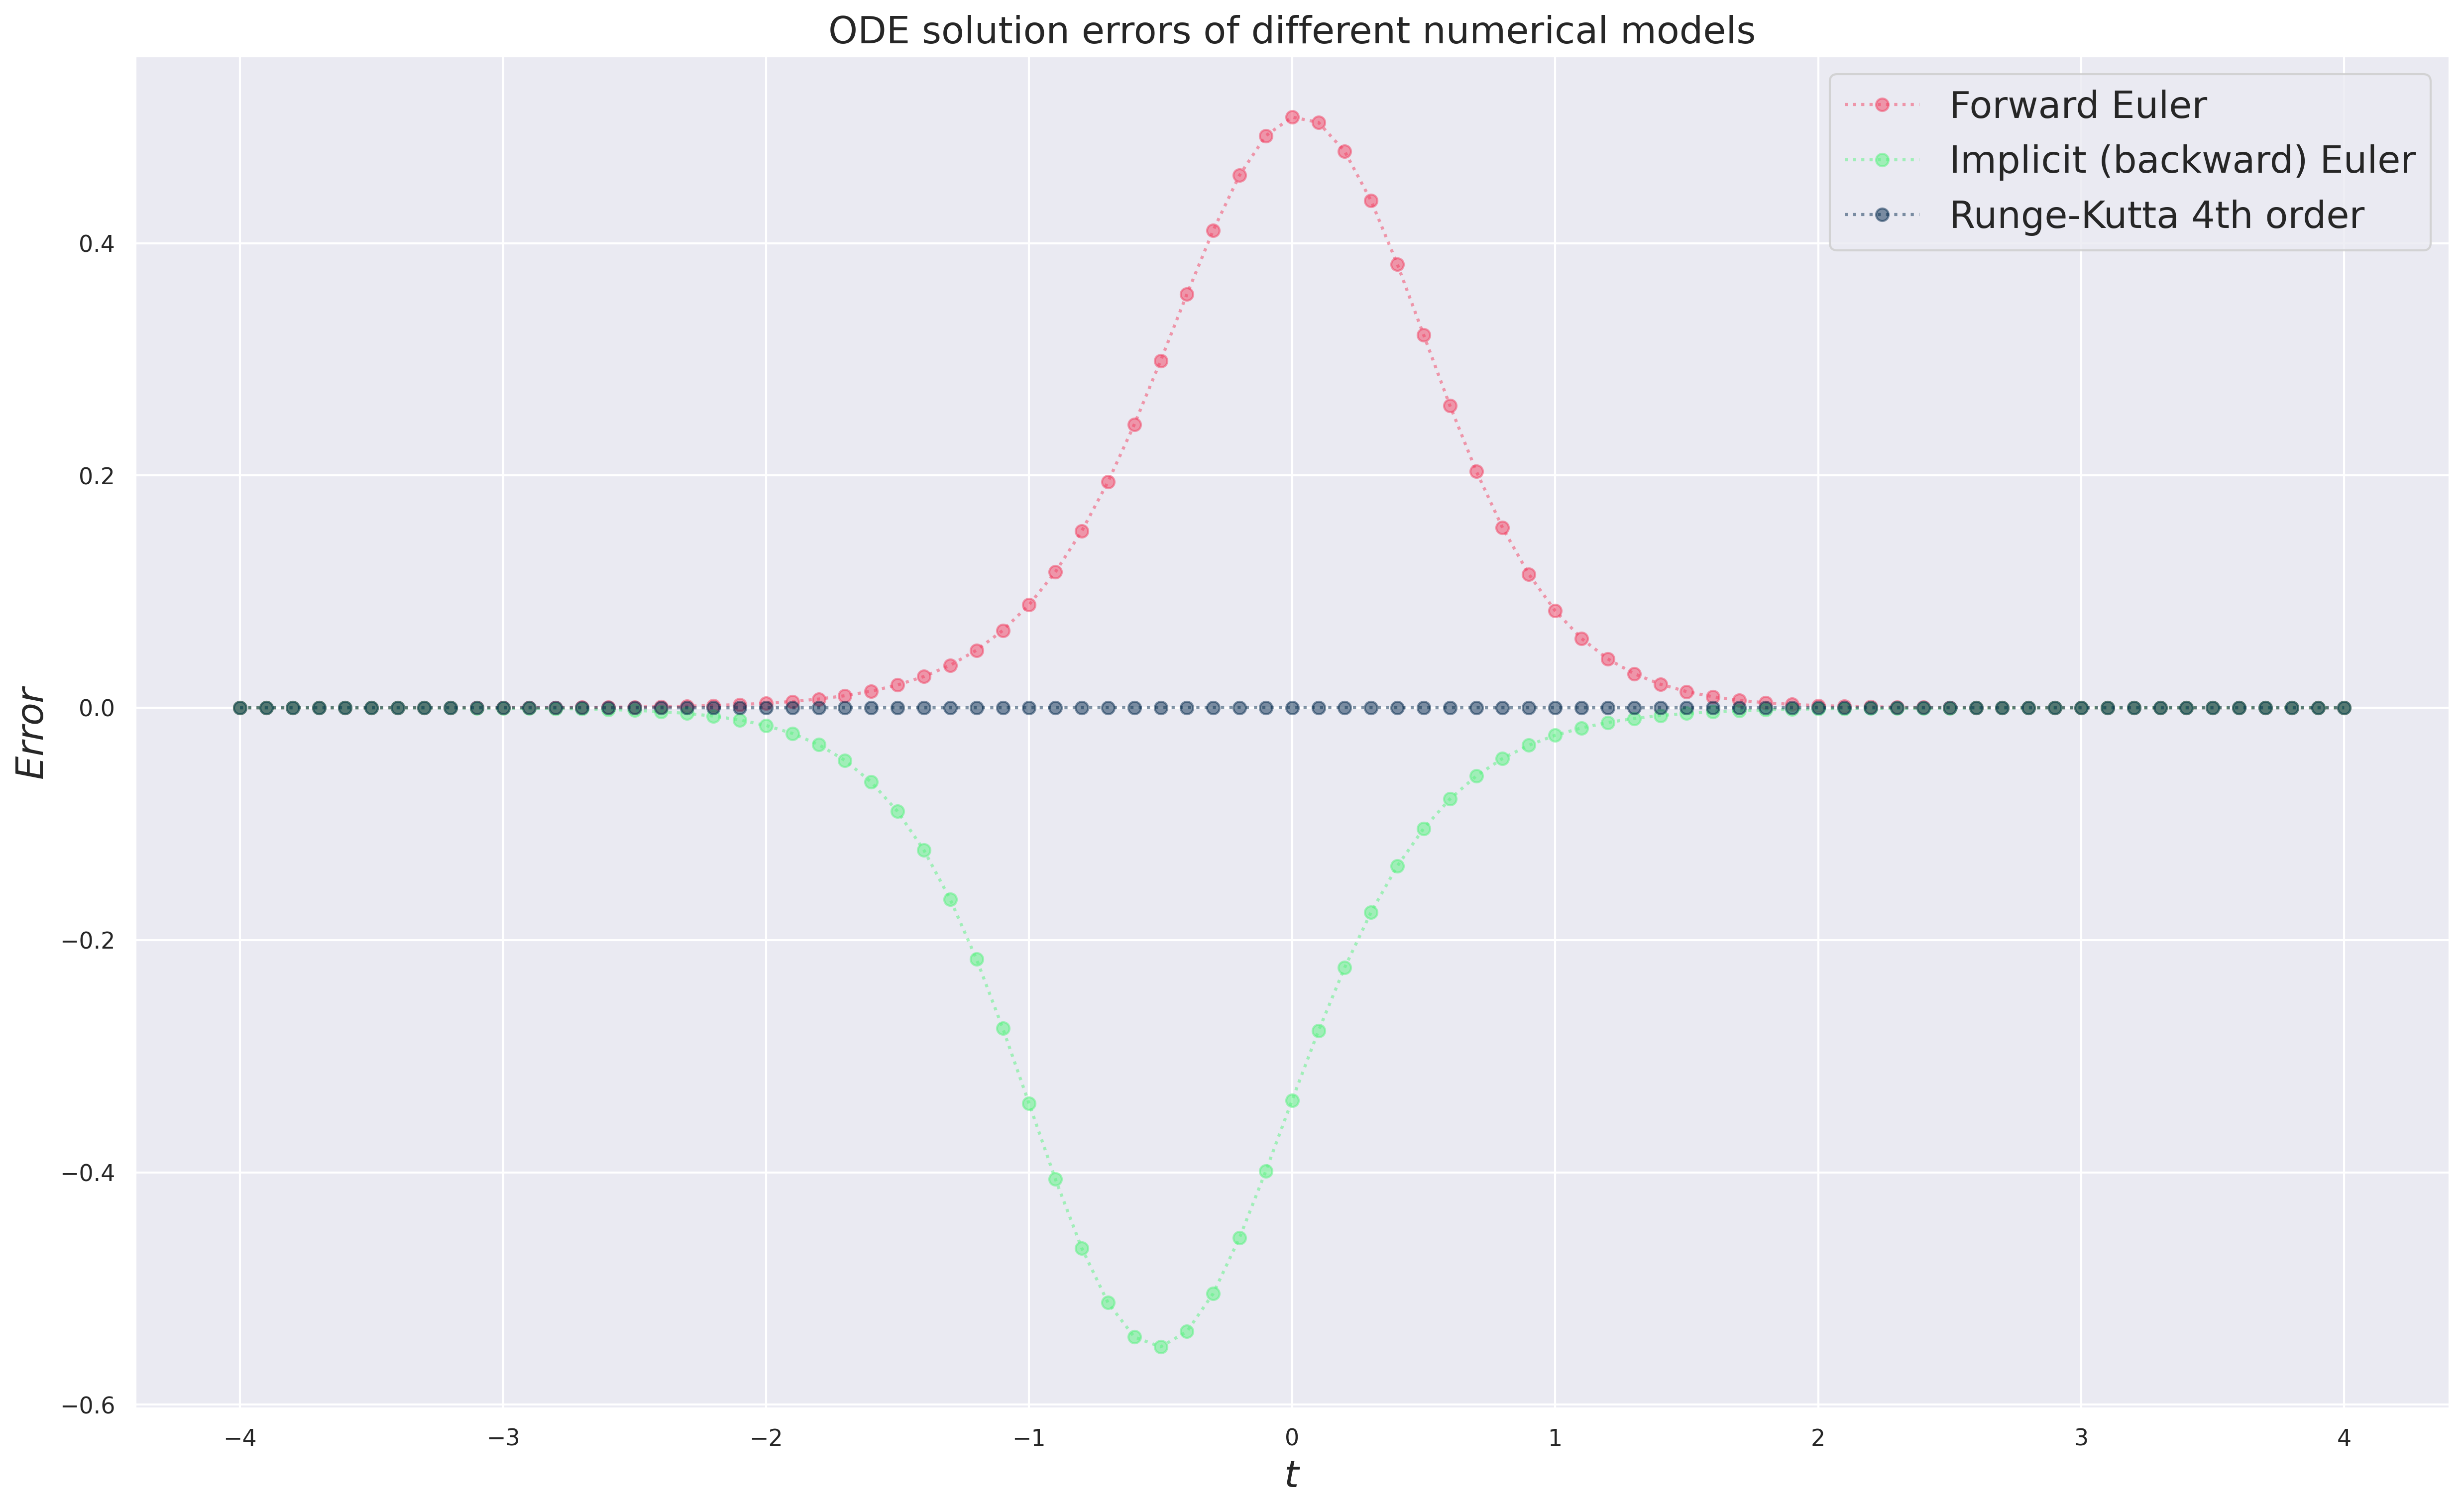

In [ ]:
plt.title('ODE solution errors of different numerical models', fontsize=18)
t_ = np.arange(t_0, t_n + h, h)
analytical = sigmoid(t_)
for sol, label, color in zip(
    (f_euler_sol, imp_euler_sol, runge_sol),
    ('Forward Euler', 'Implicit (backward) Euler', 'Runge-Kutta 4th order'),
    ('#F24162', '#58F380', '#092E51')):
  error = (analytical - sol['y'].ravel())
  plt.plot(sol['t'], error, alpha=.5, label=label, color=color, ls=':', marker='o')
plt.xlabel(r'$t$', fontsize=18)
plt.ylabel(r'$Error$', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
errors = []

for h_ in np.linspace(1e-2, 1e0, 10):
  t_ = np.arange(t_0, t_n + h_, h_)
  analytical = sigmoid(t_)

  f_euler_sol = solve_ode([analytical[0]], f=f, t_0=t_0, t_n=t_n, h=h_, method='euler')['y'].ravel()
  imp_euler_sol = solve_ode([analytical[0]], f=f, t_0=t_0, t_n=t_n, h=h_, method='imp-euler')['y'].ravel()
  runge_sol = solve_ode([analytical[0]], f=f, t_0=t_0, t_n=t_n, h=h_, method='runge-kutta')['y'].ravel()

  for i, t in enumerate(t_):
    errors.append({'Method': 'Forward Euler', 'T': t, 'h': h_, 'Error': analytical[i] - f_euler_sol[i]})
    errors.append({'Method': 'Implicit (backward) Euler', 'T': t, 'h': h_, 'Error': analytical[i] - imp_euler_sol[i]})
    errors.append({'Method': 'Runge-Kutta 4th order', 'T': t, 'h': h_, 'Error': analytical[i] - runge_sol[i]})

In [ ]:
import plotly.express as px

In [ ]:
Errors = pd.DataFrame(errors)

fig = px.scatter_3d(
    Errors,
    x='T', y='h', z='Error',
    color='Method',
    color_discrete_map={
        'Forward Euler': '#F24162',
        'Implicit (backward) Euler': '#58F380',
        'Runge-Kutta 4th order': '#092E51'
    })
fig.update_traces(marker=dict(opacity=.8))
fig.update_layout(
    autosize=False,
    width=1500,
    height=800,)

fig.show()